## Recurrence relation

This is an example from my [notes on adjoint methods for recurrence relations](http://math.mit.edu/~stevenj/18.336/recurrence2.pdf).

In particular, we have a simple linear recurrence:
$$
x^n = Ax^{n-1} + \begin{pmatrix} 0 \\ p_n \end{pmatrix}
$$
in terms of parameters $p$, with initial condition:
$$
x^0 = b = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
$$
and
$$
A = \begin{pmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta \end{pmatrix}
$$
We execute this recurrence for $N$ steps, and at the end we compute $g(p) = (x^N_2)^2$.  The goal is to compute the partial derivatives $d g / d p_n$ for $n = 1,\ldots,N$.

In [3]:
θ = 0.1
A = [ cos(θ) sin(θ); -sin(θ) cos(θ)]
N = 100
p = rand(N)
b = [1,0]

2-element Array{Int64,1}:
 1
 0

In [4]:
# compute xᴺ
function recurrence(A, b, p)
    x = b
    for i = 1:length(p)
        x = A * x + [0,p[i]]
    end
    return x
end

recurrence (generic function with 1 method)

In [5]:
recurrence(A, b, p)

2-element Array{Float64,1}:
  9.29829
 -3.75176

Here is the implementation of $g$ and $dg/dp$ by the adjoint method, as explained in the notes.   This involves computing the recurrence "forward" to obtain $x^n$, *saving* the results for each $n$ (using a $2\times N+1$ matrix `X` here), then computing the adjoint recurrence "backward" to obtain $\lambda$ and accumulate $dg/dp$.

In [25]:
# compute g(x) = x[2]^2 from last iteration, and dg/dp, by adjoint method
function recurrence_adjoint(A, b, p)
    X = Array(Float64, 2, length(p)+1)
    X[:,1] = b
    for i = 1:length(p)
        X[:,i+1] = A * X[:,i] + [0,p[i]]
    end
    λ = [0, 2*X[2,end]]
    dgdp = Array(Float64, length(p))
    for i = length(p):-1:1
        dgdp[i] = λ[2]
        λ = A'λ
    end
    return X[2,end]^2, dgdp
end

recurrence_adjoint (generic function with 1 method)

In [26]:
recurrence_adjoint(A, b, p)

(14.07573606941016,[6.67207,6.98148,7.22113,7.38863,7.48231,7.50123,7.44519,7.31477,7.11126,6.83669  …  -4.66427,-5.22776,-5.73902,-6.19293,-6.58497,-6.91121,-7.16839,-7.35396,-7.46604,-7.50353])

For comparison, we will compute $dg/dp$ by a center difference approximation: $\partial g/\partial p_n \approx [g(p + \delta e_n) - g(p - \delta e_n)] / 2\delta$ for some small $\delta$.

In [30]:
function recurrence_FD(A, b, p, δ=1e-5)
    g = recurrence(A, b, p)[2]^2
    dgdp = Array(Float64, length(p))
    for i = 1:length(p)
        pold = p[i]
        p[i] = pold + δ
        g₊ = recurrence(A, b, p)[2]^2
        p[i] = pold - δ
        g₋ = recurrence(A, b, p)[2]^2
        dgdp[i] = (g₊ - g₋) / (2δ)
        p[i] = pold
    end
    return g, dgdp
end

recurrence_FD (generic function with 2 methods)

As we might have hoped, the answers are pretty close (limited by roundoff error and/or finite-difference error):

In [34]:
norm(recurrence_FD(A, b, p)[2] - recurrence_adjoint(A, b, p)[2])

1.5216061289064273e-6

In practice, it is really easy to make mistakes in computing derivatives of complicated functions by hand, so it is always important to check your results against a finite-difference approximation.

It is interesting to ask what the influence of the finite-difference step $\delta$ is in this problem, by plotting the error vs. $\delta$:

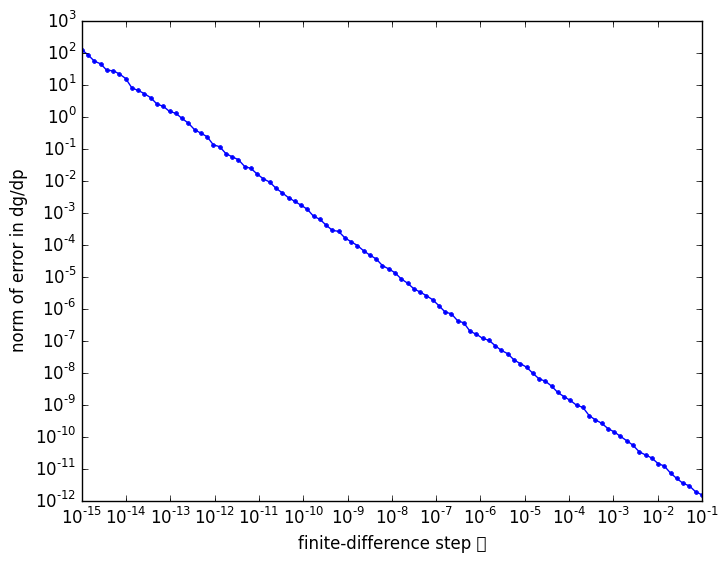

PyObject <matplotlib.text.Text object at 0x31730e050>

In [38]:
using PyPlot
δ = logspace(-15, -1, 100)
loglog(δ, [norm(recurrence_adjoint(A, b, p)[2] - recurrence_FD(A, b, p, d)[2]) for d in δ], ".-")
xlabel("finite-difference step δ")
ylabel("norm of error in dg/dp")

At first glance, this seems ridiculous: the errors get *monotonically worse* as $\delta$ decreases!  How can this be right?

The key point is to realize that our $g(p)$ depends *quadratically* on $p$, and a center-difference approximation is *exact* for a quadratic function *in exact arithmetic*.   So, *all* of the difference arises due to roundoff errors.  In the finite-difference approximation, the difference $g(p + \delta e_n) - g(p - \delta e_n)$ is the difference of two nearly equal quantities as $\delta \to 0$, so there is a large cancellation error in the result (i.e. the result arises from the *least* significant digits of $g$), and hence the error worsens with decreasing $\delta$.